### Step 1: Load Data
We start by loading the CDC Chronic Disease Indicators dataset.  
This raw dataset contains disease prevalence across states, years, and risk factors.  


In [6]:
# 0. Setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from joblib import dump

os.makedirs("outputs", exist_ok=True)
sns.set(style="whitegrid")

In [7]:
df=pd.read_csv(r"E:\\New_folder\\ML_Projects\\U.S._Chronic_Disease_Indicators.csv")

In [8]:
print("Shape:", df.shape)
print("Sample Questions (indicators) count:", df["Question"].nunique())
print(df["Question"].value_counts().head(10))

Shape: (309215, 34)
Sample Questions (indicators) count: 109
Question
Binge drinking frequency among adults who binge drink                                                     5720
Binge drinking intensity among adults who binge drink                                                     5680
Asthma mortality among all people, underlying cause                                                       5616
Chronic liver disease mortality among all people, underlying cause                                        5616
Diabetic ketoacidosis mortality among all people, underlying or contributing cause                        5616
Cerebrovascular disease (stroke) mortality among all people, underlying cause                             5616
Coronary heart disease mortality among all people, underlying cause                                       5616
Diseases of the heart mortality among all people, underlying cause                                        5616
Diabetes mortality among all people, under

### Step 2: Data Cleaning
- Drop rows where `DataValue` is missing, since this is our outcome variable.  
- Drop columns with >80% missing values.  
- Convert `DataValue` to numeric.  
- Fill remaining missing values with median (for numbers) or `"missing"` (for categories).  

This ensures our dataset is consistent and usable for modeling.  


In [9]:
# 2. Clean data
# Keep rows with DataValue (we need the value to model/visualize)
df = df.dropna(subset=["DataValue"]).copy()

# numeric version of the target
df["data_value_num"] = pd.to_numeric(df["DataValue"], errors="coerce")

# Fill numeric NaNs (other numeric columns) with median
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())

# Fill categorical NaNs with "missing"
for c in df.select_dtypes(exclude=[np.number]).columns:
    df[c] = df[c].fillna("missing")

print("After cleaning:", df.shape)


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepd

After cleaning: (209196, 35)


### Step 3: Select COPD and Obesity
We focus on:
- **Chronic Obstructive Pulmonary Disease (COPD)**  
- **Obesity among adults**  

These represent two different but impactful health conditions: one respiratory, one lifestyle-related.  


In [10]:
# 3. Choose indicators
copd_name  = "Chronic obstructive pulmonary disease among adults"
obesity_name = "Obesity among adults"

df_two = df[df["Question"].isin([copd_name, obesity_name])].copy()
print(df_two["Question"].value_counts())


Question
Obesity among adults                                  3973
Chronic obstructive pulmonary disease among adults    3141
Name: count, dtype: int64


### Step 4: Create Binary Target
We define "high prevalence" as being **above the median** for each disease.  
This allows us to frame the problem as a **classification task**.  


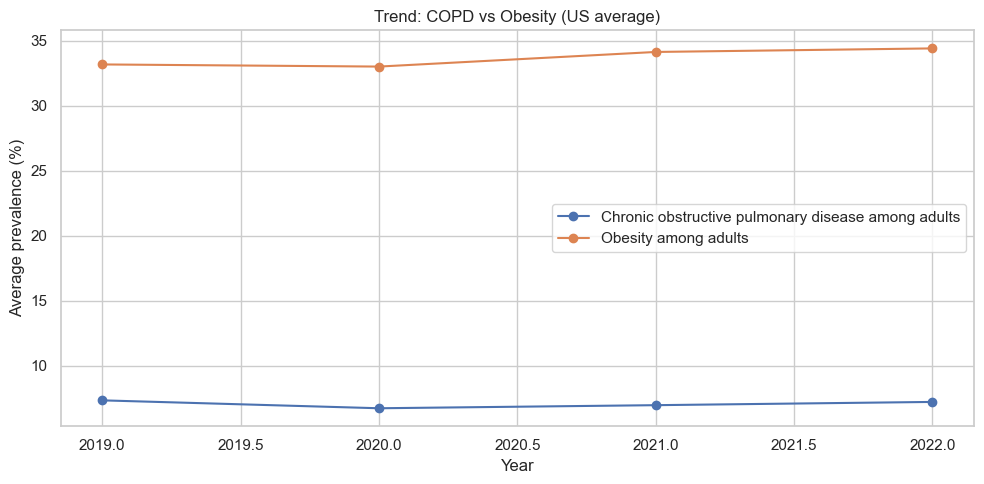

In [11]:
# 4. Trend analysis: average prevalence by year
trend = df_two.groupby(["YearStart", "Question"])["data_value_num"].mean().reset_index()

plt.figure(figsize=(10,5))
for q in [copd_name, obesity_name]:
    tmp = trend[trend["Question"] == q]
    plt.plot(tmp["YearStart"], tmp["data_value_num"], marker="o", label=q)
plt.title("Trend: COPD vs Obesity (US average)")
plt.xlabel("Year")
plt.ylabel("Average prevalence (%)")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/trend_copd_obesity.png")
plt.show()


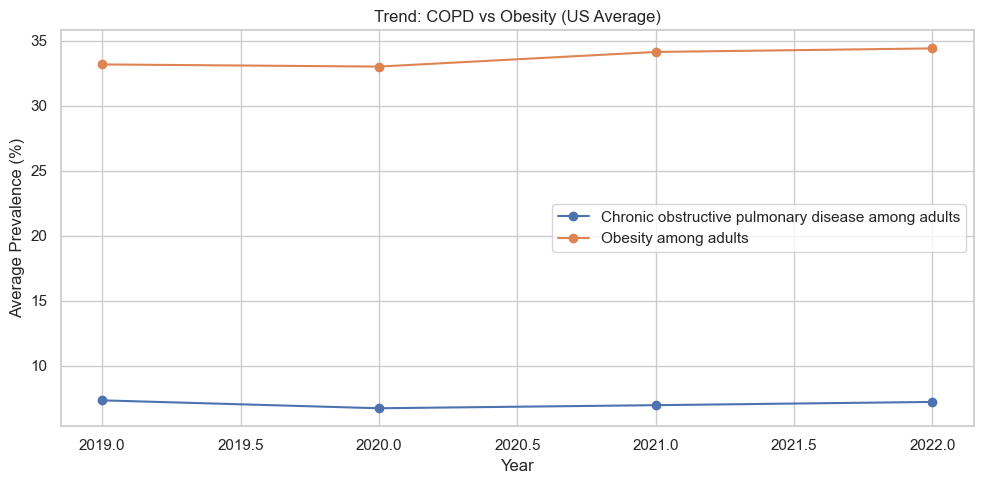

In [12]:
# Trend analysis: average prevalence by year for both diseases
trend = df_two.groupby(["YearStart", "Question"])["data_value_num"].mean().reset_index()

plt.figure(figsize=(10,5))
for q in [copd_name, obesity_name]:
    tmp = trend[trend["Question"] == q]
    plt.plot(tmp["YearStart"], tmp["data_value_num"], marker="o", label=q)

plt.title("Trend: COPD vs Obesity (US Average)")
plt.xlabel("Year")
plt.ylabel("Average Prevalence (%)")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/trend_copd_obesity.png")
plt.show()


### Step 5: Choropleth Visualization
Geographic maps help public health stakeholders quickly see which states  
are most affected, guiding **resource allocation and policy planning**.  


In [23]:
# 5a. Obesity choropleth (latest-year state average)
d = obesity_name
latest_year = df[df["Question"]==d]["YearStart"].max()
df_obs_latest = (
    df[(df["Question"]==d) & (df["YearStart"]==latest_year)]
    .groupby(["LocationAbbr","LocationDesc"], as_index=False)["data_value_num"]
    .mean()
    .rename(columns={"data_value_num":"Obesity"})
)
fig = px.choropleth(
    df_obs_latest,
    locations="LocationAbbr",
    locationmode="USA-states",
    color="Obesity",
    hover_name="LocationDesc",
    title=f"Obesity among adults — {latest_year}",
    color_continuous_scale="Reds",
    scope="usa"
)
fig.write_html("outputs/obesity_choropleth.html")
fig.show()


In [24]:
# 5b. COPD choropleth (latest-year state average)
d = copd_name
latest_year_copd = df[df["Question"]==d]["YearStart"].max()
df_copd_latest = (
    df[(df["Question"]==d) & (df["YearStart"]==latest_year_copd)]
    .groupby(["LocationAbbr","LocationDesc"], as_index=False)["data_value_num"]
    .mean()
    .rename(columns={"data_value_num":"COPD"})
)
fig = px.choropleth(
    df_copd_latest,
    locations="LocationAbbr",
    locationmode="USA-states",
    color="COPD",
    hover_name="LocationDesc",
    title=f"COPD among adults — {latest_year_copd}",
    color_continuous_scale="Reds",
    scope="usa"
)
fig.write_html("outputs/copd_choropleth.html")
fig.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_13024\3903519639.py:13: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



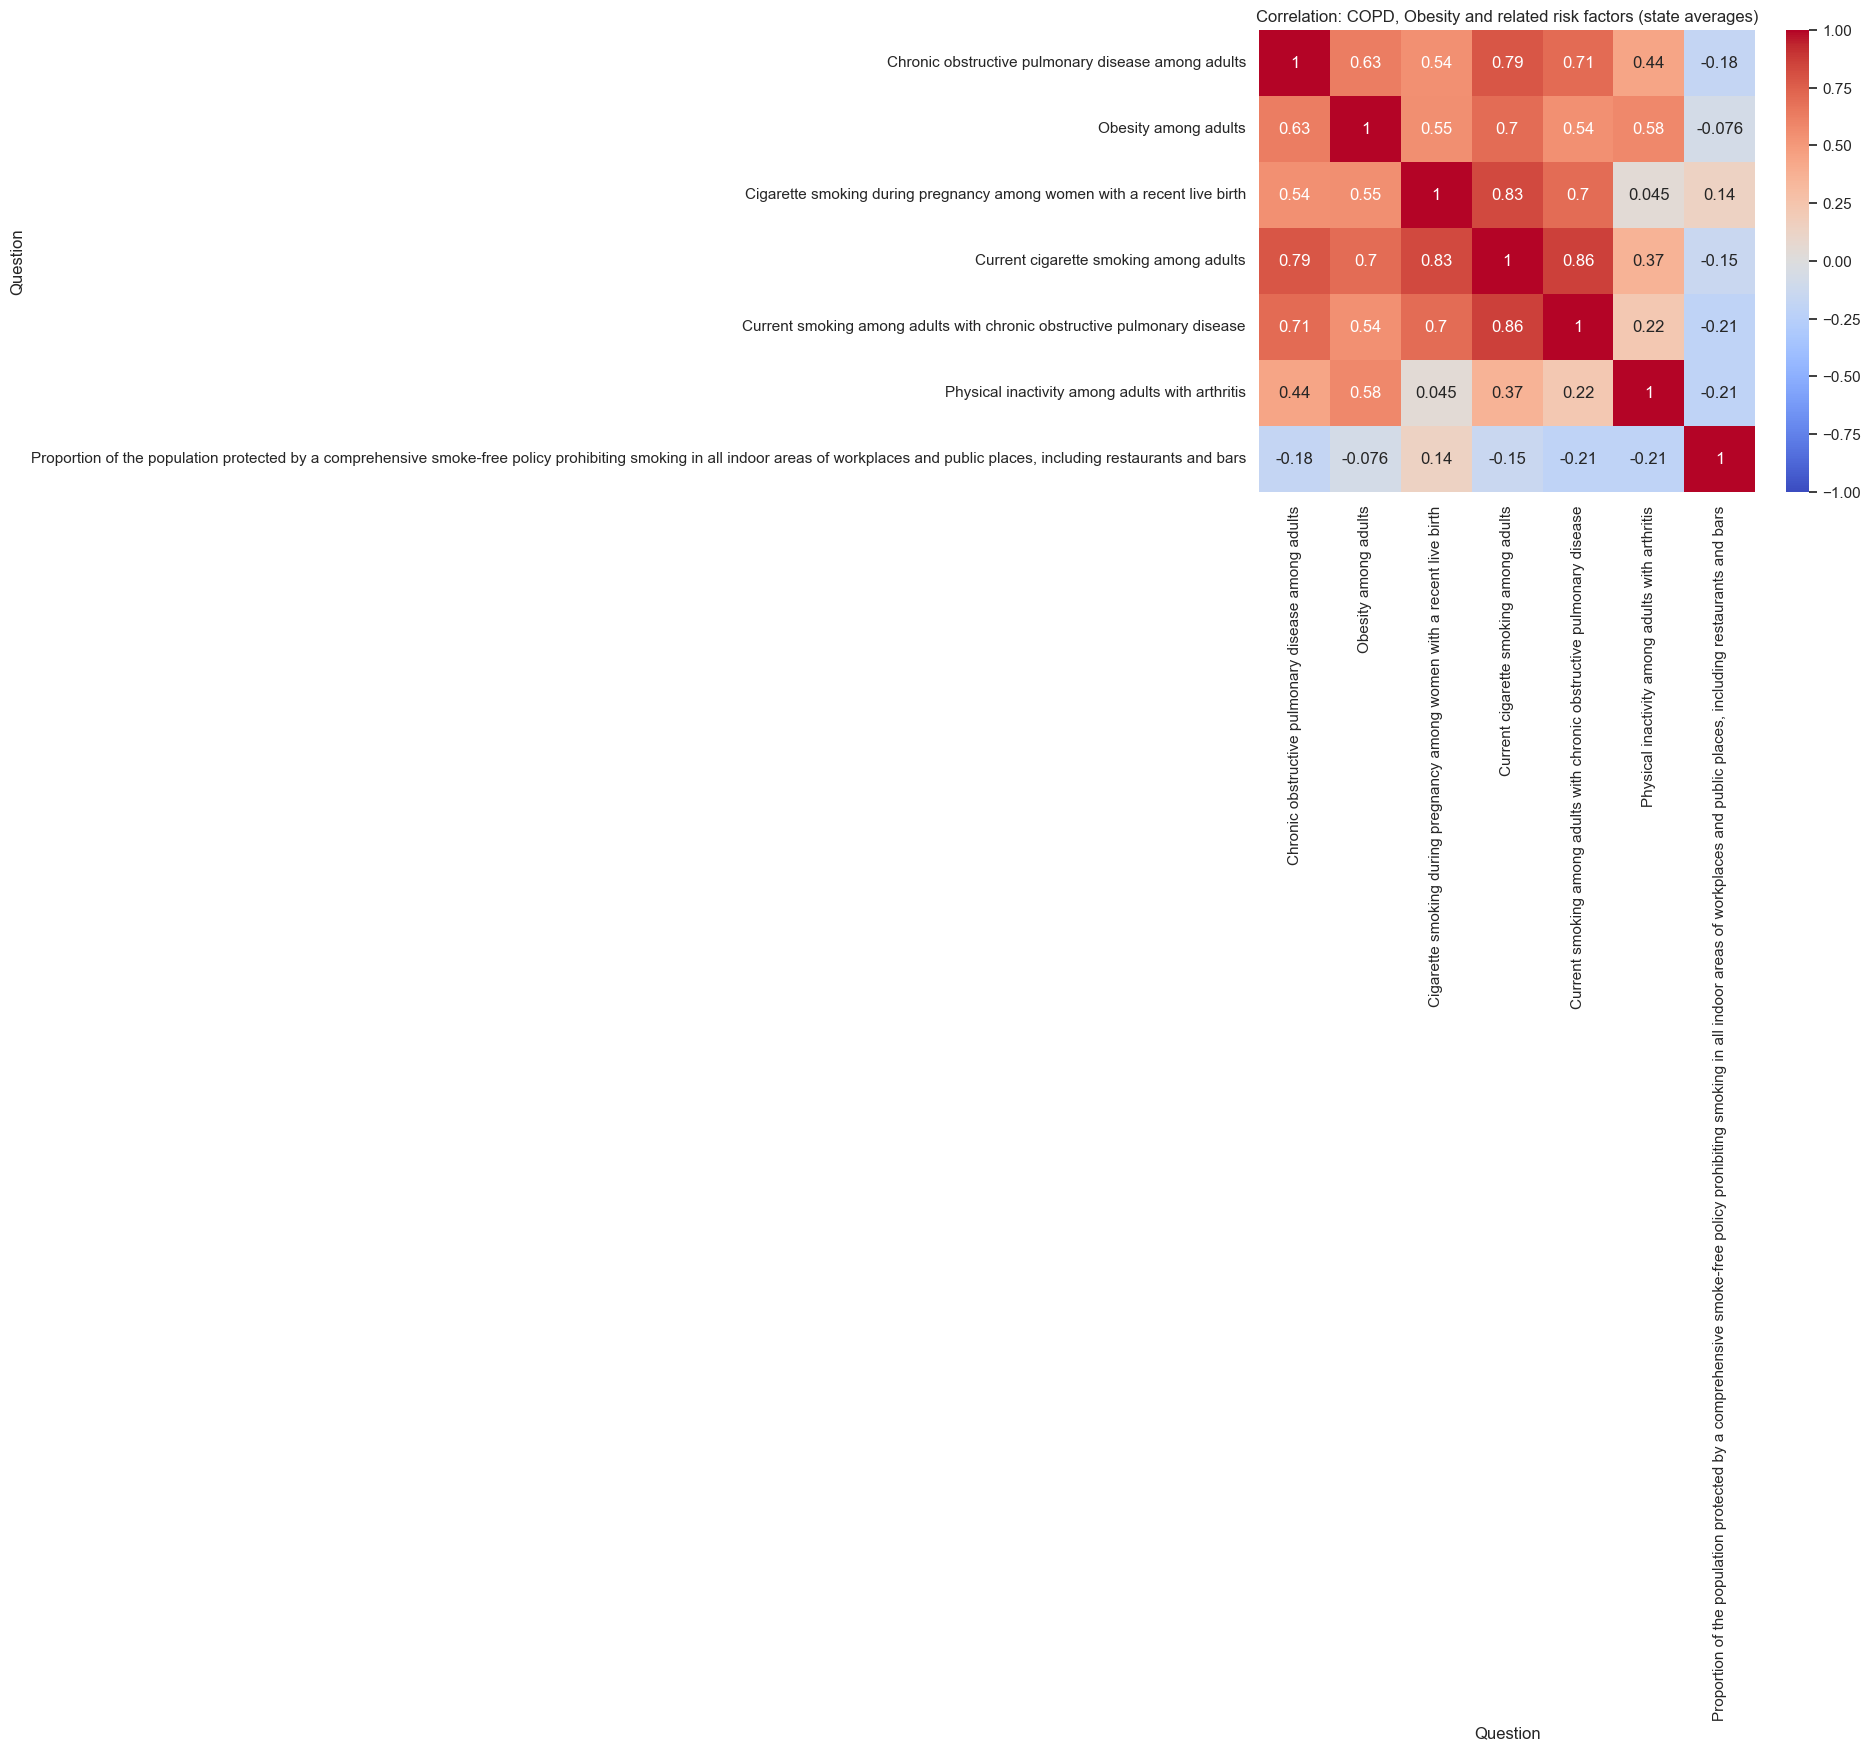

In [25]:
# 6. State-level pivot and correlation for a few related indicators
# Build pivot with mean prevalence per state across available questions
pivot = df.pivot_table(index="LocationAbbr", columns="Question", values="data_value_num", aggfunc="mean")

# pick columns related to smoking, physical inactivity if available, plus COPD & Obesity
candidates = [c for c in pivot.columns if ("smoking" in c.lower() or "physical inactivity" in c.lower())]
selected_cols = [col for col in [copd_name, obesity_name] + candidates if col in pivot.columns]
corr = pivot[selected_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation: COPD, Obesity and related risk factors (state averages)")
plt.tight_layout()
plt.savefig("outputs/correlation_heatmap.png")
plt.show()


In [26]:
# 7. Function: prepare data for one indicator (binary target by median)
def prepare_for_model(df, indicator, features=None):
    df_i = df[df["Question"] == indicator].copy()
    median = df_i["data_value_num"].median(skipna=True)
    df_i["high_prevalence"] = (df_i["data_value_num"] >= median).astype(int)

    if features is None:
        features = ["YearStart","LocationAbbr","LocationDesc","Stratification1","StratificationCategory1",
                    "LowConfidenceLimit","HighConfidenceLimit"]
    features = [f for f in features if f in df_i.columns]
    X = df_i[features].copy()
    y = df_i["high_prevalence"].copy()

    # drop rows where all features are missing
    mask = ~X.isna().all(axis=1)
    return X[mask], y[mask], median

# Example usage:
X_copd, y_copd, med_copd = prepare_for_model(df, copd_name)
X_obesity, y_obesity, med_obesity = prepare_for_model(df, obesity_name)
print("COPD rows:", X_copd.shape[0], "Obesity rows:", X_obesity.shape[0])


COPD rows: 3141 Obesity rows: 3973


### Step 8: Build Models
We train separate **Random Forest classifiers** for COPD and Obesity.  
Caveat: since location (state) is included, the model may "memorize states,"  
so results must be interpreted with caution.  


Accuracy: 0.9888712241653418 ROC AUC: 0.9994692144373674
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       314
           1       0.99      0.99      0.99       315

    accuracy                           0.99       629
   macro avg       0.99      0.99      0.99       629
weighted avg       0.99      0.99      0.99       629



['outputs/rf_copd.joblib']

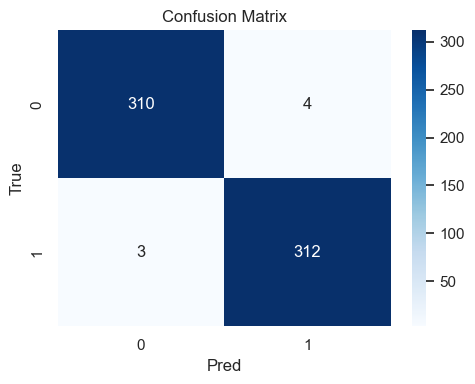

In [31]:
# 8. Function to train and evaluate a Random Forest pipeline
def train_rf_pipeline(X, y, random_state=42):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)

    # identify numeric vs categorical
    numeric_feats = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_feats = [c for c in X_train.columns if c not in numeric_feats]

    # simple preprocessors
    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
                         ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

    preproc = ColumnTransformer([("num", num_pipe, numeric_feats),
                                 ("cat", cat_pipe, categorical_feats)])

    pipe = Pipeline([("preproc", preproc),
                     ("rf", RandomForestClassifier(n_estimators=150, random_state=random_state, n_jobs=-1))])

    # fit
    pipe.fit(X_train, y_train)

    # predict & metrics
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    print("Accuracy:", acc, "ROC AUC:", roc)
    print(classification_report(y_test, y_pred))

    # confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.tight_layout()

    return pipe, (X_test, y_test, y_pred, y_proba)

# Example run:
rf_copd, copd_test_tuple = train_rf_pipeline(X_copd, y_copd)
dump(rf_copd, "outputs/rf_copd.joblib")



### Step 9: Feature Importance
We examine which features contribute most to predicting prevalence.  
This highlights **risk factors** and helps explain the model.  


In [32]:
# 9. Map feature importances back to feature names
def get_feature_importances(pipe):
    # get numeric feature names
    numeric_feats = pipe.named_steps["preproc"].transformers_[0][2]
    # get ohe names
    ohe = pipe.named_steps["preproc"].transformers_[1][1].named_steps["onehot"]
    cat_feats = pipe.named_steps["preproc"].transformers_[1][2]
    if hasattr(ohe, "get_feature_names_out"):
        ohe_names = list(ohe.get_feature_names_out(cat_feats))
    else:
        ohe_names = []
        for i, cats in enumerate(ohe.categories_):
            ohe_names += [f"{cat_feats[i]}_{v}" for v in cats]

    feature_names = list(numeric_feats) + ohe_names
    importances = pipe.named_steps["rf"].feature_importances_
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
    return imp_df

imp_copd = get_feature_importances(rf_copd)
imp_copd.head(20).to_csv("outputs/copd_feature_importances.csv", index=False)
print("Top features (COPD):")
print(imp_copd.head(10))


Top features (COPD):
                                       feature  importance
1                           LowConfidenceLimit    0.401860
2                          HighConfidenceLimit    0.341024
115                   Stratification1_Age >=65    0.022110
117        Stratification1_Asian, non-Hispanic    0.019803
113                  Stratification1_Age 18-44    0.017893
121                   Stratification1_Hispanic    0.015490
123  Stratification1_Multiracial, non-Hispanic    0.010919
0                                    YearStart    0.010223
118        Stratification1_Black, non-Hispanic    0.007204
122                       Stratification1_Male    0.006338


In [ ]:
try:
    import shap
    explainer = shap.Explainer(rf_copd.named_steps["rf"], rf_copd.named_steps["preproc"].transform(copd_test_tuple[0]))
    shap_vals = explainer(rf_copd.named_steps["preproc"].transform(copd_test_tuple[0]))
    shap.summary_plot(shap_vals, rf_copd.named_steps["preproc"].transform(copd_test_tuple[0]))
except Exception as e:
    print("SHAP not available or failed; falling back to RF importances. Error:", e)


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

 99%|===================| 1248/1258 [00:28<00:00]        

SHAP not available or failed; falling back to RF importances. Error: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.366867, while the model output was 0.240000. If this difference is acceptable you can set check_additivity=False to disable this check.


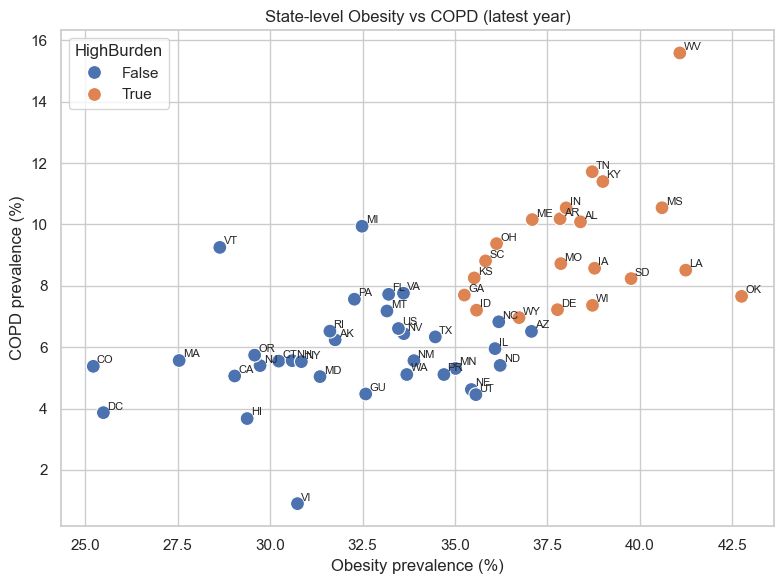

Top double-burden states:
   LocationAbbr    Obesity       COPD
37           OK  42.752632   7.657895
19           LA  41.242105   8.511765
53           WV  41.082353  15.592308
26           MS  40.600000  10.546154
43           SD  39.763158   8.236364
18           KY  39.000000  11.400000
13           IA  38.776471   8.573333
52           WI  38.719048   7.364706
44           TN  38.711765  11.720000
1            AL  38.394737  10.085714
16           IN  38.005882  10.542105
25           MO  37.863158   8.725000
2            AR  37.842105  10.186667
8            DE  37.772222   7.223077
22           ME  37.089474  10.160000
54           WY  36.733333   6.963636
36           OH  36.123810   9.376471
42           SC  35.826316   8.812500
14           ID  35.582353   7.207143
17           KS  35.520000   8.257895
10           GA  35.252632   7.700000


In [34]:
# 11. Double burden scatter (latest year for both)
# merge previously created df_obs_latest and df_copd_latest
merged = pd.merge(df_obs_latest, df_copd_latest, on=["LocationAbbr","LocationDesc"], how="inner")
merged = merged.dropna(subset=["Obesity","COPD"])
merged["HighBurden"] = (merged["Obesity"] > merged["Obesity"].median()) & (merged["COPD"] > merged["COPD"].median())

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x="Obesity", y="COPD", hue="HighBurden", s=100)
for i, row in merged.iterrows():
    plt.text(row["Obesity"]+0.1, row["COPD"]+0.1, row["LocationAbbr"], fontsize=8)
plt.title("State-level Obesity vs COPD (latest year)")
plt.xlabel("Obesity prevalence (%)")
plt.ylabel("COPD prevalence (%)")
plt.tight_layout()
plt.savefig("outputs/double_burden_scatter.png")
plt.show()

print("Top double-burden states:")
print(merged[merged["HighBurden"]].sort_values(["Obesity","COPD"], ascending=False)[["LocationAbbr","Obesity","COPD"]])


### Step 8: Recommendations

**Policy Level**  
- COPD: Expand smoking cessation programs, regulate air quality, improve access to lung screenings.  
- Obesity: Support healthier school meals, encourage physical activity through urban design, implement nutrition awareness campaigns.  

**Individual Level**  
-  Avoid smoking/secondhand smoke to lower COPD risk.  
-  Eat more fruits/vegetables, reduce sugary drinks to prevent obesity.  
-  Walk 30 minutes daily → improves both lung and metabolic health.  

By combining geographic insights, machine learning, and prevention strategies,  
we bridge data science with actionable public health impact.  
